# AB Testing 

Basic AB Testing Template

In [107]:
import scipy.stats as scs
import pandas as pd, numpy as np
import matplotlib.pyplot as plt


def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    group_bern = scs.bernoulli(0.5)

    # initiate bernoulli distributions to randomly sample from
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

### Baseline Conversion Rate and Lift

In [191]:
# code examples presented in Python
bcr = 0.20  # baseline conversion rate
d_hat = 0.2 # difference between the groups

### Control Group (A) and Test Group (B)

In [192]:
# A is control; B is test
N_A = 1000
N_B = 1000

ab_data = generate_data(N_A, N_B, bcr, d_hat)

ab_data.head()

,converted,group
0,0,A
1,0,B
2,1,B
3,0,A
4,1,B


### 2. Run the Test

In [193]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

ab_summary

,converted,total,rate
group,,,
A,193,996,0.193775
B,167,1004,0.166335


### 3. Compare the Two Groups

In [194]:
A_total = ab_summary['total']['A']
B_total = ab_summary['total']['B']
A_converted = ab_summary['converted']['A']
B_converted = ab_summary['converted']['B']
A_cr = ab_summary['rate']['A']
B_cr = ab_summary['rate']['B']

p_A = A_cr 
p_B = B_cr 

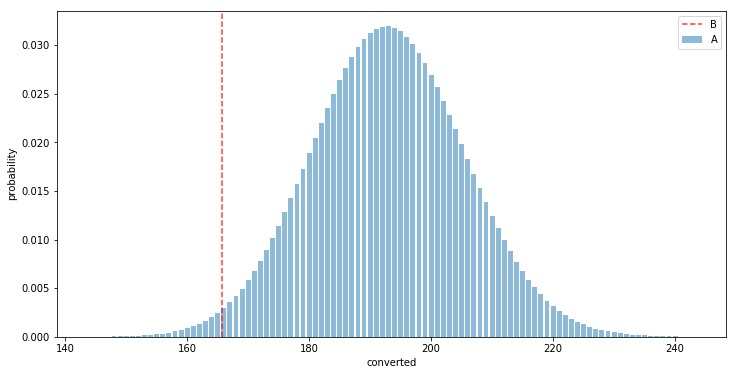

In [195]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=B_cr * A_total, c='red', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')
plt.legend(['B','A'])

### Binomial Distribution

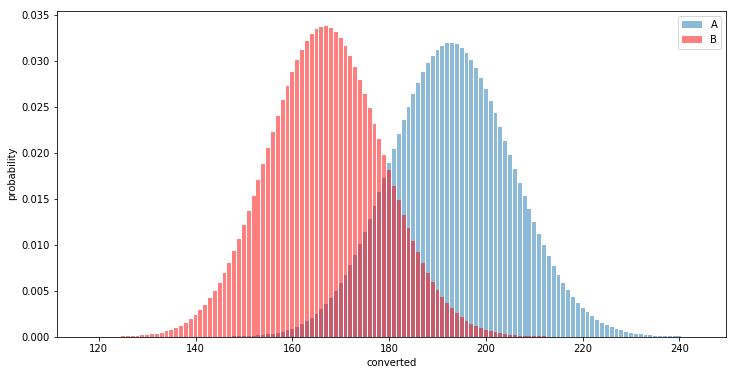

In [196]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5, color = 'red')
plt.xlabel('converted')
plt.ylabel('probability')
plt.legend(['A','B'])